# Bias variance and dimensionality reduction on Kaggle House Prices

In this notebook we use the *House Prices – Advanced Regression Techniques* dataset from [Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques). It contains information about houses in Ames, Iowa. Each house has many features such as area, quality, year built, and location. The goal is to predict the selling price of a house based on these features.

In this notebook, we study how model complexity and data dimensionality affect prediction accuracy. We do this through two main experiments.

### Bias–Variance Trade-off

We test how generalization changes as models become more complex. A simple model has high bias. It cannot capture all patterns in the data. A complex model has low bias but high variance, meaning it can overfit and memorize noise. We use `Ridge`, `Lasso`, `ElasticNet`, `Decision Trees`, `Random Forests`, and `Neural Networks` to see how this balance shifts.

We also explore `regularization. L1 (Lasso) and L2 (Ridge) regularization` penalize large coefficients, which keeps models simpler and improves generalization. For neural networks, we use `early stoppin`g to prevent overfitting by stopping training when performance stops improving.

The complexity curves show that **Ridge performs best** because it balances flexibility and stability. **Lasso removes weak features** and simplifies the model. **Decision Trees overfit quickly** when allowed to grow deep. **Random Forests reduce that overfitting** by averaging many trees. **Neural Networks improve when early stopping is used**, showing how regularization helps learning stop at the right time.

### Curse of Dimensionality & Dimensionality Reduction

We then study how the number of features affects model performance. When we add random, useless features, all models get worse. This happens because high dimensional data spreads out, distances become less meaningful, and models learn noise instead of signal. This effect is called the curse of dimensionality.

To reduce this effect, we use `PCA` (Principal Component Analysis). PCA combines correlated numeric features into fewer, uncorrelated components that keep most of the information. This simplifies the input while filtering out noise.

We find that **Ridge** and the **Neural Network** benefit from PCA, while **Random Forests** stay mostly unchanged. The explained variance plot shows that about 25–30 PCA components capture almost all the numeric information. This means we can reduce dimensionality safely without losing predictive power.

In [25]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["axes.grid"] = True

In [26]:
# Load the training data
df = pd.read_csv("../data/train.csv")

First off we're dropping the outliers we found in the EDA-Report because of their low saleprice but high quality.

We're also preparing the target variable by applying `log transform` to SalePrice. You do this for a couple reasons:

* It compresses large values and spreads small ones.
* Reduced the right skew in the data
* Makes the distribution closer to normal, which helps lineair models fit better
* Stabilizes variance, so model errors are more balances across price ranges

We're also splitting the data into `features` and `targets` because:

* This separates what you want to predict (target) from what you use to predict (features)
* `X` holds the independent variabesl like area, year and quality
* `Y ` holds the dependent variabel: `SalePrice`

In [27]:
# Drop known outlier rows if they exist
to_drop = [i for i in [523, 1298] if i in df.index]
if to_drop:
    df = df.drop(index=to_drop).reset_index(drop=True)

# Prepare target variable
# Apply log transform to SalePrice to reduce skew
y = np.log1p(df["SalePrice"]).values  # type: ignore

# Drop SalePrice from features
X = df.drop(columns=["SalePrice"])

Then the next step is to list numerical and categorical columns, because:

* This tells us which preprocessing steps to apply
* Ex. Numerical columns often need scaling or normalization
* And categorical columns need encoding into numbers

A clear sparation between the two avoids errors and keeps your preprocessing consistent.

In [28]:
# Separate numerical and categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

## OneHotEncoder and Preprocessing
Below we define the OneHotEncoder and preprocessing for the numeric and categorical columns.

The OneHotEncoder converts text categories into binary columns so models can process them. **The try-except block** keeps compatibility with older sklearn versions that use a different argument name.

Numeric preprocessing fills any missing numbers with the median to standardizes the scale. `Standardization` improves model stability, especially for models sensitive to feature scales such as in our case: lineair regression.

Categorical preprocessing fills missing values with the most common category and converts them into numeric vectors. The `ColumnTransformer` runs both numeric and categorical preprocessing in one step.

In [29]:
# Create OneHotEncoder compatible with both old and new sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # Fill missing numeric values with median
    ("scaler", StandardScaler()),                    # Standardize values to mean=0, std=1
])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing categories with most common value
    ("onehot", ohe),                                       # Convert categories to numeric one-hot vectors
])

# Combine both transformations into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),  # Apply numeric pipeline to numeric columns
        ("cat", categorical_transformer, cat_cols),  # Apply categorical pipeline to categorical columns
    ],
    remainder="drop"  # Drop unused columns
)

# X and Y Train split
Even though we defined `y` and `X` above, we only seperate the target column from the features. This prepares the full dataset for modelling but does **not** create training or testing subsets.

Thats why we use `train_test_split`, here the exact difference between the two:

* The first split `(X and y)` separates **what to predict** from **what to use for prediction**.
* The second split `(train_test_split)` separates **data to train the model** from **data to evaluate it**.

You do need both: 

1. X and y tell the model which columns are inputs and which is the output.
2. X_train, X_valid, y_train, y_valid prevent overfitting and help you measure true performance.

Without the second split, the model would be tested on the same data it trained on, giving you inflated and unreliable scores.

In [30]:
# Split data into training and validation sets
# Use the same random state for consistency
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

## RSME and Feature Names
Below we define the `RSME` and `Feature Names`. 

RSME is defined as followed: 

**RMSE** = √Σ(Pi – Oi)2 / n

where:

* Σ is a fancy symbol that means “sum”
* Pi is the predicted value for the ith observation in the dataset
* Oi is the observed value for the ith observation in the dataset
* n is the sample size

To understand how to **interpret** the RSME in our case we need to understand what we're predicting. We are predicting `SalePrice`, but your target `y` is **log-transformed** using np.log1p().
That means your RMSE is measured in **log-dollars**, not in real dollars.

### How to interpret RSME

* RMSE shows the average prediction error between predicted and true log-prices.
* Because we used `log1p`, the errors correspond to percentage-like differences rather than raw price differences.
* To get a sense of the error in dollars, you can exponentiate the RMSE:

**Example:**
- If RMSE = 0.12
- Then np.expm1(0.12) ≈ 0.127
- That means the model’s average prediction error is about **12.7 percent of the actual price**.

**Practical guide:**
* RMSE below 0.15 → strong performance (about 15 percent average error).
* RMSE around 0.20 → moderate performance.
* RMSE above 0.25 → weak generalization or underfitting/overfitting.

### Feature Names
`get_feature_names` rebuilds the cilumn names after the preprocesser transforms the data. So after one-hot encoding, each categorical column becomes many new binary columns, each representing one of the categories. This function collects both numeric and expanded categorical feature names, so you can then later interpret model coefficients or visualize importance scores.



In [31]:
# Compute Root Mean Squared Error (RMSE)
# Measures average prediction error in target units
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Get feature names after preprocessing
# Useful for plotting model coefficients or feature importance
def get_feature_names(preprocessor):
    feat_names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" and trans == "drop":
            continue  # Skip dropped columns
        if name == "num":
            feat_names.extend(cols)  # Keep numeric column names
        elif name == "cat":
            ohe = trans.named_steps["onehot"]
            try:
                names = ohe.get_feature_names_out(cols)  # New sklearn version
            except Exception:
                names = ohe.get_feature_names(cols)  # Old sklearn version
            feat_names.extend(names)
    return np.array(feat_names, dtype=object)

# Complexity Curves
Here we define `alpha`, which helps us study the bias and variance balance for our model.

So, `fit_score_alpha` trains and evaluates a regularized linear model (like Ridge, Lasso, or ElasticNet) for many values of the regularization strength alpha. It records how model performance changes as alpha changes. 

This is important because **regularization** controls how complex our model is. Alpha is the regularization paramaters, it helps find the sweet spot between over- and underfitting.

### def fit_score_alpha
The **input** the func takes is model_name for plotting purposes, estimator_class (Ridge, Lasso, ElasticNet), param_name which is usually alpha, alphas which is a list of alpha values to test and extra kwargs are optional extra arguments for the model like l1_ration in ElasticNet.

The model loops over the alpha lists and creates a new model. That model is then wrapped inside a pipeline with the preprocesser, so all scaling and encoding steps are consistenly each run.

The pipeline is then fit on the training set. The model then learns the relationship between features and target under the chosen alpha. The fitted model then predicts prices for both training and validation set, the RSME is also computed for both predictions. The training RSME will show how well the model fits data it has seen and Validation shows how well it generalizes to unseen data.

All results will be stored in two lists `results_grid` one for training and one for validation.

In [32]:
# Complexity curves for linear models: Ridge, Lasso, ElasticNet

alphas = np.logspace(-4, 2, 12) # alpha grid from 1e-4 to 1e2
results_grid = []

def fit_score_alpha(model_name, estimator_class, param_name="alpha", alphas=alphas, extra_kwargs=None):
    extra_kwargs = extra_kwargs or {}
    train_scores, valid_scores = [], []
    for a in alphas:
        est = estimator_class(**{param_name: a}, **extra_kwargs)
        pipe = Pipeline([("prep", preprocessor), ("model", est)])
        pipe.fit(X_train, y_train)
        y_tr_pred = pipe.predict(X_train)
        y_va_pred = pipe.predict(X_valid)
        train_scores.append(rmse(y_train, y_tr_pred))
        valid_scores.append(rmse(y_valid, y_va_pred))
    return np.array(train_scores), np.array(valid_scores)

Below we test a couple lineair regularization method over the same alpha grid:

* **Ridge** adds an L2 penalty that shrinks coefficients smoothly but keeps all features.
* **Lasso** adds an L1 penalty that forces some coefficients to zero, performing feature selection.
* **ElasticNet** mixes both penalties, controlled by l1_ratio (here 0.5 gives equal weight to L1 and L2).

In [33]:
# Train Ridge, Lasso, and ElasticNet models across alpha values
# Record RMSE for both training and validation sets
ridge_train, ridge_valid = fit_score_alpha(
    "Ridge", Ridge, extra_kwargs={"random_state": RANDOM_STATE}
)

lasso_train, lasso_valid = fit_score_alpha(
    "Lasso", Lasso, extra_kwargs={"random_state": RANDOM_STATE, "max_iter": 10000}
)

enet_train, enet_valid = fit_score_alpha(
    "ElasticNet", ElasticNet, extra_kwargs={"random_state": RANDOM_STATE, "max_iter": 10000, "l1_ratio": 0.5}
)

Below we plot the results of the different experiments

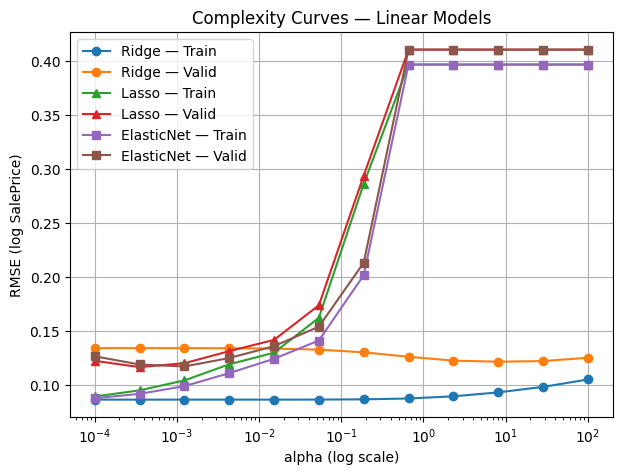

In [34]:
# Plot train and validation RMSE for each linear model across alpha values
plt.figure()
plt.semilogx(alphas, ridge_train, marker="o", label="Ridge — Train")
plt.semilogx(alphas, ridge_valid, marker="o", label="Ridge — Valid")
plt.semilogx(alphas, lasso_train, marker="^", label="Lasso — Train")
plt.semilogx(alphas, lasso_valid, marker="^", label="Lasso — Valid")
plt.semilogx(alphas, enet_train, marker="s", label="ElasticNet — Train")
plt.semilogx(alphas, enet_valid, marker="s", label="ElasticNet — Valid")
plt.xlabel("alpha (log scale)")
plt.ylabel("RMSE (log SalePrice)")
plt.title("Complexity Curves — Linear Models")
plt.legend()
plt.show()


### Alpha 
Up until alpha region **1e-2** the regularization is weak, the model fit the training data tightly. The Training RSME is low, which means a near-perfect fit. Validation is slightly higher, showing a mild overfit. This means the models are quite flexible.

Right around **1e-1** does the regularization begin to control the complexity, the training RSME icreases slightly and the validation RSME decreases, showing better generalization. This is often the "sweet spot", where bias and variance are balanced.

Around the higher alpha regions **10-0 and up** does the regeularization become too strong, the coefficient shrinkts toward zero, the model lose flexibility and underfits the data. The training and validation RSME both rise sharply. The predictions converge toward the mean of SalePrice.

### Comparing Models
- **Ridge (L2)** stays smooth and stable, performs best at moderate alpha.
- **Lasso (L1)** jumps more sharply because it zeroes out coefficients, making it sensitive to alpha changes.
- **ElasticNet** behaves between the two, blending Ridge stability and Lasso sparsity.

The takeaway from this is that the best alpha near the lowest validation RSME is, around the **1e-2** or **1e-1**. `Ridge` shows the most stable generalization across the range, so this is likely the best baseline for our data. `Lasso` and `ElasticNet` start to lose alot of information, too much as alpha grows.

---

## Refitting
Now that we know the best alpha values we can refit both models with the best values found in the complexity curves. The pipeline we set up ensures preprocessing and fitting are applied consistently, so that wont be an issue. After fitting, we extract the trained coefficients, which represents how strongly each feature influences `log SalePrice`. 

#### Features and Coefficients
Quick reminder before diving into the Ridge and Lasso refit:

- **Feature**: Is a variable we use to predict `SalePrice`, things like `GrLivArea`, `OverallQual` and the encoded categories. Each feature represents a measurable property of the house. Models use these features as inputs to learn how they relate to the target variable.
- **Coefficient**: Is the weight the model assigns to a feature. It shows how strongly that feature influences the prediction. A positive coefficient means the feature value increases in our case means predicted SalePrice increases and negative the opposite. 

So, when you look at coefficients, you are seeing **how much each feature matters** in predicting SalePrice.

### Ridge and Lasso Refit

`Ridge` keeps all coefficients, only shrinking their size. Because we add an L2 penalty, which discourages large coefficient values. The model still keeps every feature in the equation, but their influence is reduced. We smooth the model: no feature dominaties, all contribute a bit. This should make the model more stable and less sensitive to noise.

`Lasso` drives many coefficients exactly to zero, performing implicit feature selection. Because we add an L1 penalty, which can push some coefficients to exactly zero. Features with zero coefficients are effectively removed from the model. This means Lasso performs automatic feature selection: it keeps only the most relevant predictors.

We also establisch `coef_df` here, which allows us to comapre which features ech model uses and how strongly they weight them. 

In [35]:
# Refit Ridge and Lasso with chosen alpha values to inspect coefficients
ridge = Pipeline([
    ("prep", preprocessor),
    ("model", Ridge(alpha=1.0, random_state=RANDOM_STATE))
]).fit(X_train, y_train)

lasso = Pipeline([
    ("prep", preprocessor),
    ("model", Lasso(alpha=0.01, random_state=RANDOM_STATE, max_iter=10000))
]).fit(X_train, y_train)

# Extract feature names after preprocessing
feat_names = get_feature_names(ridge.named_steps["prep"])

# Get model coefficients for both Ridge and Lasso
ridge_coef = ridge.named_steps["model"].coef_
lasso_coef = lasso.named_steps["model"].coef_

# Combine into one DataFrame for comparison
coef_df = pd.DataFrame({
    "feature": feat_names,
    "ridge": ridge_coef,
    "lasso": lasso_coef
})

## Positive Coefficient values

Below we plot the top 20 positive and negative coefficient values.

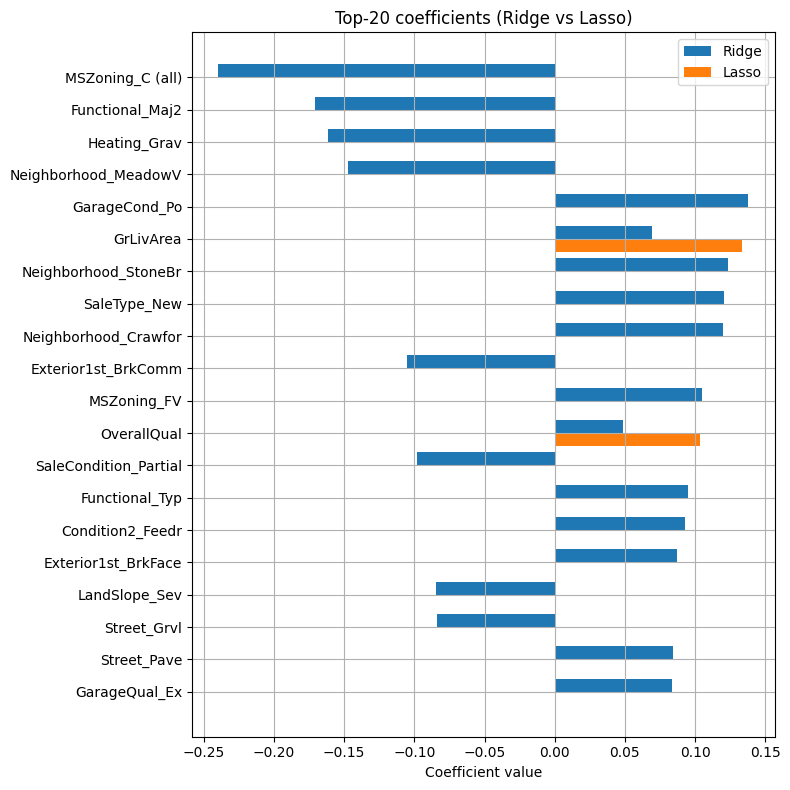

In [36]:

coef_df["abs_max"] = np.maximum(np.abs(coef_df["ridge"]), np.abs(coef_df["lasso"]))
top = coef_df.sort_values("abs_max", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(8,8))
idx = np.arange(len(top))
ax.barh(idx-0.2, top["ridge"], height=0.4, label="Ridge")
ax.barh(idx+0.2, top["lasso"], height=0.4, label="Lasso")
ax.set_yticks(idx); ax.set_yticklabels(top["feature"])
ax.invert_yaxis()
ax.set_title("Top-20 coefficients (Ridge vs Lasso)")
ax.set_xlabel("Coefficient value")
ax.legend()
plt.tight_layout(); plt.show()

As we mentioned before, positive coefficients mean higher feature values *increases* the predicated SalePrice. Negative coefficients mean higher feature value *decreases* predicted SalePrice. The longer the bar, the stronger the influence.

#### Ridge vs Lasso
Ridge (blue) includes all features. Every variable has some nonzero weight, even if small. Lasso (orange) includes fewer bars because it set many weaker coefficients to zero.

We see overlap for key features like GrLivArea and OverallQual, which both models identify as important. For other variables, Ridge still assigns small weights, while Lasso removes them entirely.

This means that the refit worked as intended, Ridge spreads influence across many correlated features. It keeps more nuance but can be harder to interpert. Lasso Simplifies the model by keeping only a few strong predictors, this does make it easy to interpret, but may lose some information.

The takeaway of this is that `Ridge` is better when we want a stable prediction and you think most features matter a bit. `Lasso` is better when you want feature selection or simpler interpertation. 

Both agree on the main drivers of SalePrice: living area, overall quality, and high-value neighborhoods.

---

### Decision Tree Regressor

We are looking at Decision Trees now because we are comparing **different model types** to learn how **model complexity** affects generalization.

Ridge and Lasso are **linear models**. They assume a straight-line relationship between features and target. We explored how regularization (alpha) controls complexity in that context. The coefficients there show which features matter most, because linear models are interpretable that way.

Decision Trees are **nonlinear models**. They make predictions by splitting the data into regions instead of using coefficients. You cannot interpret them through feature weights, so you study their complexity differently, by varying `max_depth`.

So with this plot we ask *"How does generalization change as the tree becomes more complex?" "When does the tree start to overfit?"*

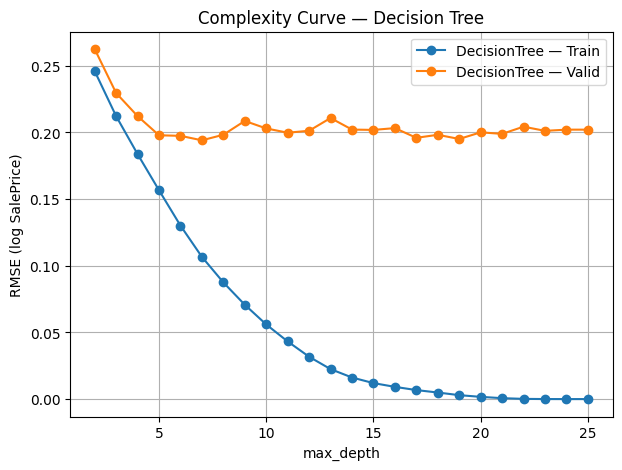

In [37]:

# 2) COMPLEXITY CURVES — DECISION TREES (max_depth sweep)

depths = list(range(2, 26))
tree_train, tree_valid = [], []

for d in depths:
    tree = Pipeline([("prep", preprocessor),
                     ("model", DecisionTreeRegressor(max_depth=d, random_state=RANDOM_STATE))])
    tree.fit(X_train, y_train)
    y_tr = tree.predict(X_train)
    y_va = tree.predict(X_valid)
    tree_train.append(rmse(y_train, y_tr))
    tree_valid.append(rmse(y_valid, y_va))

plt.figure()
plt.plot(depths, tree_train, marker="o", label="DecisionTree — Train")
plt.plot(depths, tree_valid, marker="o", label="DecisionTree — Valid")
plt.xlabel("max_depth"); plt.ylabel("RMSE (log SalePrice)"); plt.title("Complexity Curve — Decision Tree")
plt.legend(); plt.show()

Here, complexity is controlled by `max_depth`, which limits how many splits the tree can make. A small depth forces the model to make only a few decisions, while a large depth lets it split repeatedly until nearly every observation is perfectly fitted.

The loop trains a new tree for each depth value from 2 to 25. For every tree, it computes RMSE on both the training and validation sets. The results are stored and then plotted.

The blue curve drops steadily as depth increases because the tree becomes more flexible and fits the training data better. By depth 20 or higher, the training RMSE is almost zero, meaning the tree memorized the training data.

The orange curve measures how well the model performs on unseen data. It improves at first, then stops improving around depth 6 to 8, and stays flat afterward. This means that deeper trees no longer help the model generalize.

---

## RandomForest 

After seeing the results on the decision tree we also wanna look at **Random Forest averaging** and how this affects the prediction stability and generalization.

A Random Forest is an type of Decision Trees. Each tree learns on a random subset of the data and features. Their predictions are averaged to reduce variance. Increasing `n_estimators` means you add more trees to this ensemble.

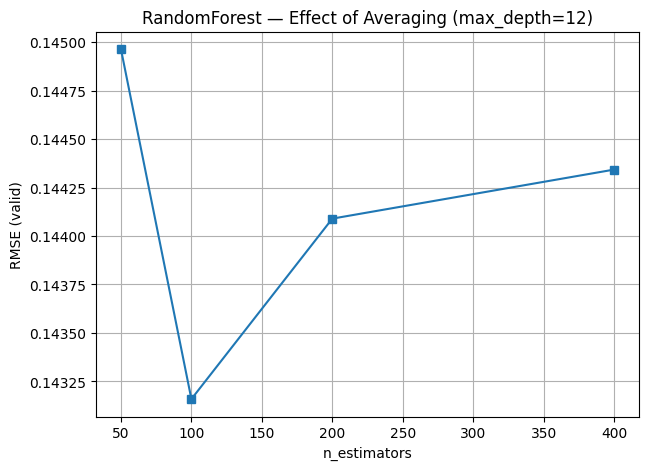

In [38]:
# RandomForest — test effect of averaging across more trees
n_estimators = [50, 100, 200, 400]  # number of trees to test
rf_valid = []

for n in n_estimators:
    # Build pipeline with preprocessing and Random Forest model
    rf = Pipeline([
        ("prep", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=n,       # number of trees in the forest
            max_depth=12,         # fixed depth to control complexity
            random_state=RANDOM_STATE,
            n_jobs=-1             # use all CPU cores
        ))
    ])
    rf.fit(X_train, y_train)
    y_va = rf.predict(X_valid)
    rf_valid.append(rmse(y_valid, y_va))  # store validation RMSE

# Plot validation RMSE against number of trees
plt.figure()
plt.plot(n_estimators, rf_valid, marker="s")
plt.xlabel("n_estimators")
plt.ylabel("RMSE (valid)")
plt.title("RandomForest — Effect of Averaging (max_depth=12)")
plt.show()


The plot shows that validation **RMSE** improves slightly when we go from 50 to 100 trees, then levels off. After that, adding more trees gives almost no improvement, only small random variation.

When we say the tree is 'stabilized', we mean that adding more trees to the Random Forest no longer changes our predictions much. At first, when we only have a few trees, each tree makes slightly different guesses, so the overall result jumps around. As we add more trees, their errors start to cancel each other out. The model becomes calmer, more balanced, and less sensitive to random noise in the data.

Once the forest has enough trees, its average prediction stops moving noticeably, it’s stable (100 in our case). Adding extra trees at that point doesn’t make our predictions better, it only costs more time to train.

## Neural Networks
Here we train two neural network regressors `(MLPRegressor)` to study how early stopping helps prevent overfitting.
Both networks have the same structure: two hidden layers with 64 neurons and ReLU activation. The only difference is how training stops.

In the first model, we disable early stopping. The network runs for a fixed number of 500 iterations, even if it starts overfitting. It keeps adjusting weights, which can cause it to memorize the training data and lose generalization.

In the second model, we enable early stopping. This adds a built-in validation check. During training, the model monitors performance on a small slice of the training data. If it stops improving for 20 consecutive rounds, training halts automatically. This keeps the model from over-training.

When we say early stopping helps regularize the model, we mean it keeps the learning process from going too far. Once the network has learned enough patterns to generalize, it stops before memorizing noise.

In simple terms:
without early stopping, the model keeps learning until it overfits; with early stopping, it stops at the right moment, when the learning has stabilized.

In [39]:
# Regularization and early stopping with MLPRegressor

# a) Train neural network without early stopping
mlp_noes = Pipeline([
    ("prep", preprocessor),
    ("model", MLPRegressor(
        hidden_layer_sizes=(64, 64),  # two hidden layers of 64 neurons each
        activation="relu",
        learning_rate_init=1e-3,
        max_iter=500,                 # stop after 500 iterations
        random_state=RANDOM_STATE,
        early_stopping=False          # no early stopping
    ))
])
mlp_noes.fit(X_train, y_train)
y_pred_noes = mlp_noes.predict(X_valid)

# b) Train neural network with early stopping
mlp_es = Pipeline([
    ("prep", preprocessor),
    ("model", MLPRegressor(
        hidden_layer_sizes=(64, 64),
        activation="relu",
        learning_rate_init=1e-3,
        max_iter=2000,                # allow longer training
        early_stopping=True,          # enable early stopping
        n_iter_no_change=20,          # stop if no improvement for 20 epochs
        validation_fraction=0.15,     # use 15% of training data for validation
        random_state=RANDOM_STATE
    ))
])
mlp_es.fit(X_train, y_train)
y_pred_es = mlp_es.predict(X_valid)


In [40]:

print(f"MLP no-ES  -> RMSE={rmse(y_valid, y_pred_noes):.4f} | MAE={mean_absolute_error(y_valid, y_pred_noes):.4f} | R2={r2_score(y_valid, y_pred_noes):.4f}")
print(f"MLP w/ ES  -> RMSE={rmse(y_valid, y_pred_es):.4f} | MAE={mean_absolute_error(y_valid, y_pred_es):.4f} | R2={r2_score(y_valid, y_pred_es):.4f}")

MLP no-ES  -> RMSE=0.2070 | MAE=0.1479 | R2=0.7458
MLP w/ ES  -> RMSE=0.1948 | MAE=0.1297 | R2=0.7750


These results show us that the model **Without early stopping** has a higher RSME (20%) and MAE (15%) and a lower R^2. Which means that it fits the training ata too tightly and performs worse one hte validation set.

The model **With early stopping** performs better across all metrics. RMSE and MAE are lower, meaning its predictions are closer to the true prices on average. R² is higher, meaning it explains more of the variation in SalePrice.

For us, this confirms that early stopping is an effective regularization tool for neural networks. It keeps the model simpler, improves validation accuracy, and reduces the risk of overfitting.

---

## Robustness Check

We run repeated 5-fold CV, twice. That gives 10 out-of-fold evaluations per model. We wrap preprocessing and the model in one pipeline to avoid leakage. We score each fold with RMSE and R2, then report the mean and the standard deviation across the 10 folds.

In [41]:

# Repeated K-Fold cross-validation to test robustness

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)

def cv_rmse_summary(name, estimator):
    # Pipeline prevents leakage, applies same prep in every fold
    pipe = Pipeline([("prep", preprocessor), ("model", estimator)])
    # Cross-validate with RMSE and R2
    scores = cross_validate(pipe, X, y,
    scoring=("neg_mean_squared_error", "r2"),
    cv=cv, n_jobs=-1)
    rmse_scores = np.sqrt(-scores["test_neg_mean_squared_error"])
    r2_scores = scores["test_r2"]
    print(f"[CV] {name:<28} RMSE={rmse_scores.mean():.4f}±{rmse_scores.std():.4f} | R2={r2_scores.mean():.4f}±{r2_scores.std():.4f}")
    return rmse_scores, r2_scores

cv_rmse_summary("Ridge(alpha=1.0)", Ridge(alpha=1.0, random_state=RANDOM_STATE))
cv_rmse_summary("Lasso(alpha=0.01)", Lasso(alpha=0.01, random_state=RANDOM_STATE, max_iter=10000))
cv_rmse_summary("DecisionTree(max_depth=12)", DecisionTreeRegressor(max_depth=12, random_state=RANDOM_STATE))
cv_rmse_summary("RandomForest(200, depth=12)", RandomForestRegressor(n_estimators=200, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1))

[CV] Ridge(alpha=1.0)             RMSE=0.1187±0.0087 | R2=0.9111±0.0125
[CV] Lasso(alpha=0.01)            RMSE=0.1301±0.0078 | R2=0.8929±0.0160
[CV] DecisionTree(max_depth=12)   RMSE=0.2033±0.0111 | R2=0.7398±0.0243
[CV] RandomForest(200, depth=12)  RMSE=0.1391±0.0074 | R2=0.8776±0.0169


(array([0.1449191 , 0.1325434 , 0.15247058, 0.14061028, 0.12712196,
        0.13603091, 0.13711458, 0.14531528, 0.13096581, 0.14392134]),
 array([0.87541814, 0.88365408, 0.83967283, 0.89132318, 0.8933293 ,
        0.86678708, 0.88750456, 0.86211856, 0.89950585, 0.87655848]))

Lower RMSE is better. Higher R2 is better. The ± value shows variability across folds. Smaller ± means more stable performance.

Because our target is log SalePrice, RMSE maps to a percentage-like error. Rough guide from the means:
• Ridge ≈ 12.6 percent
• Lasso ≈ 13.9 percent
• RandomForest ≈ 14.9 percent
• Decision Tree ≈ 22.5 percent

### What this says about the models

Ridge is best on both accuracy and stability here. Lasso is close but slightly worse, which fits the idea that shrinking without zeroing works well when many features carry signal. The single Decision Tree performs worst and varies more, which matches its higher variance. The Random Forest improves over a single tree but does not beat Ridge with these settings and depth cap.

### Why this check matters

A single train-valid split can fluke. Repeated K-Fold averages over many splits, so we get a reliable estimate of out-of-sample performance and its variability. This confirms our earlier story about bias and variance, and it supports picking Ridge as our baseline under current preprocessing and tuning.

---

# Dimensionality Reduction and Curse
We build a preprocessing pipeline that treats numeric and categorical features correctly, then we add optional PCA on numeric features only. We wrap everything with the model in a single Pipeline, so the exact same steps apply during training and validation. We add a small evaluator to train on the holdout split and report RMSE, MAE, and R2.

High dimensional feature spaces increase distance between points and make models noisy. This hurts generalization. PCA reduces numeric dimensionality by projecting features onto a smaller set of orthogonal components that retain most variance. We keep one-hot encoded categories out of PCA, because those columns are sparse indicators where linear combinations lose meaning.

We call `build_preprocessor(use_pca=False)` for the baseline. Then we call `build_preprocessor(use_pca=True, n_components=k)` to test reduced numeric spaces with k components. We pass the preprocessor and a model to eval_model_with_preprocessor to measure holdout performance. Lower RMSE and higher R2 after PCA signal that dimensionality reduction helped. If scores get worse, we reduced too aggressively or the model benefits from full detail.


In [42]:
from sklearn.decomposition import PCA
from sklearn.base import clone

# Helper: build a preprocessor with optional PCA on numeric features only
def build_preprocessor(use_pca: bool = False, n_components: int | None = None):
    """
    Build a ColumnTransformer where PCA, if enabled, is applied only to numeric features.
    """
    # OneHotEncoder compatibility across sklearn versions
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

    # Numeric branch: impute, scale, optional PCA
    num_steps = [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
    if use_pca:
        # Choose n_components ≤ number of numeric features
        num_steps.append(("pca", PCA(n_components=n_components, random_state=RANDOM_STATE)))

    numeric_transformer_local = Pipeline(steps=num_steps)

    # Categorical branch: impute then one-hot encode
    categorical_transformer_local = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", ohe),
    ])

    # Combine both branches into one preprocessor, drop anything else
    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer_local, num_cols),
            ("cat", categorical_transformer_local, cat_cols),
        ],
        remainder="drop"
    )

# Helper: fit a model with a given preprocessor on the holdout split, return metrics and pipeline
def eval_model_with_preprocessor(model, preproc):
    """Fit model with given preprocessor on holdout split; return RMSE, MAE, R2, and the trained pipeline."""
    pipe = Pipeline([("prep", preproc), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    return {
    "rmse": rmse(y_valid, y_pred),
    "mae": mean_absolute_error(y_valid, y_pred),
    "r2": r2_score(y_valid, y_pred),
    "pipeline": pipe
    }

## Adding noise
We prepare a clean numeric representation with imputation and scaling. We keep categories out because we want to control where we add noise. We then capture the current numeric dimensionality. We define a function `add_numeric_noise_features` that appends synthetic Gaussian noise features. These features contain no signal about `SalePrice`. They only add dimensions. We plan to add 0, 20, 50, and 100 noise columns to train and validation numeric arrays. Then we will train a few baseline models on these expanded inputs and watch validation error.

#### What this shows

As we add more useless features, distances between points inflate and models chase noise. Generalization gets worse. Linear models with regularization degrade slowly. Random Forests resist some noise due to averaging, then plateau or slip. MLPs feel the extra dimensions unless early stopping and regularization keep them in check.

We want to demonstrate the curse of dimensionality in a controlled way. After we see performance drop with added noise, we will motivate PCA on the numeric branch to reduce dimensions and recover accuracy.

In [43]:
#Effect of rising dimensionality by adding noise features
# We show the curse of dimensionality before we try PCA
from sklearn.utils import check_random_state

def add_numeric_noise_features(X_array, n_noise=50, rng=RANDOM_STATE):
    # Add Gaussian noise features to an already preprocessed numeric array
    rs = check_random_state(rng)
    noise = rs.normal(0, 1, size=(X_array.shape[0], n_noise))
    return np.hstack([X_array, noise])

In [44]:
# Numeric-only pipeline where we will inject noise at the right stage
numeric_only_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# Fit on numeric columns of the TRAIN set to avoid leakage into validation
X_num_train = numeric_only_pipe.fit_transform(X_train[num_cols])
X_num_valid = numeric_only_pipe.transform(X_valid[num_cols])

# Baseline dimensionality after numeric preprocessing, without PCA
num_dim = X_num_train.shape[1]
noise_dims = [0, 20, 50, 100]   # How many extra pure-noise features to add
noise_results = []

# Models we will test under rising dimensionality
base_models = {
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1),
    "MLP": MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=500, early_stopping=True, random_state=RANDOM_STATE),
}

^^^

### Simply put what we've just done:

The *“curse of dimensionality”* happens when we have too many features compared to how much data we have. In our case we have quite alot of comments and necessairily not alot of rows.

Think of every feature (like area, year built, or quality) as a separate direction in space. One feature means a line. Two features make a flat grid. Three features make a cube. When we add more features, that cube becomes something with many, many directions, like a shape that’s impossible to picture.

Here’s what goes wrong when that happens:

* Data spreads out. In high dimensions, every house ends up far from every other house. There are no close neighbors anymore, so models struggle to find patterns.
* Noise increases. When we add features that don’t matter, models start paying attention to random fluctuations instead of real signals.
* Models need more data. Every extra feature multiplies the space we need to cover with data points. With limited data, most of that space is empty.
* Overfitting gets easier. The model can always find some combination of random features that fits the training data but fails on new data.

In this code, we purposely add random “noise features”, columns that contain only nonsense values. These features have no real relationship with `SalePrice`. As we add more of them, our models’ performance should drop.

That drop shows the curse in action. Too many irrelevant features confuse the model, make distances less meaningful, and reduce accuracy.

---

We already added random noise to the numeric features. Now we need to put everything back together so our models can use both numeric and categorical data again.

Normally, we would let the `ColumnTransformer` handle this automatically, but since we added noise manually, we join the parts ourselves.

Here’s what happens:

1. We take our numeric data that now includes noise.
2. We separately process the categorical data (fill missing values and turn categories into one-hot numbers).
3. We combine both sets side by side into one full dataset.

This gives us a complete version of the data that includes both the real features and the fake noise columns. We can now train models on it and see how the extra noisy dimensions affect their performance.

In [45]:
from scipy import sparse  # imported if we later switch to sparse matrices

def concat_num_cat_manual(X_num_train_mod, X_num_valid_mod):
    # Build a fresh categorical pipeline with imputation and one hot encoding
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", ohe),
    ])

    # Fit on training categoricals only, then transform validation to avoid leakage
    X_cat_train = cat_pipe.fit_transform(X_train[cat_cols])
    X_cat_valid = cat_pipe.transform(X_valid[cat_cols])

    # Concatenate modified numeric features with encoded categoricals
    # Shapes: (n_samples, num_dim_with_noise + n_cat_onehot)
    X_tr = np.hstack([X_num_train_mod, X_cat_train])
    X_va = np.hstack([X_num_valid_mod, X_cat_valid])

    return X_tr, X_va

We now test how much performance drops as we add more noise features. We start with our clean numeric data, then add 0, 20, 50, or 100 random columns. After that, we merge the noisy numeric data with the categorical data, so each model sees a complete dataset again.

For every noise level, we train each model: Ridge, Random Forest, and MLP on the noisy training set and measure RMSE on the validation set. We store the results and plot them to see how the models react to rising dimensionality.

This shows how the “curse of dimensionality” affects different model types. Linear models and neural networks usually degrade faster because they rely on every input dimension. Random Forests handle some noise better since they average many trees, but too much noise still hurts them.

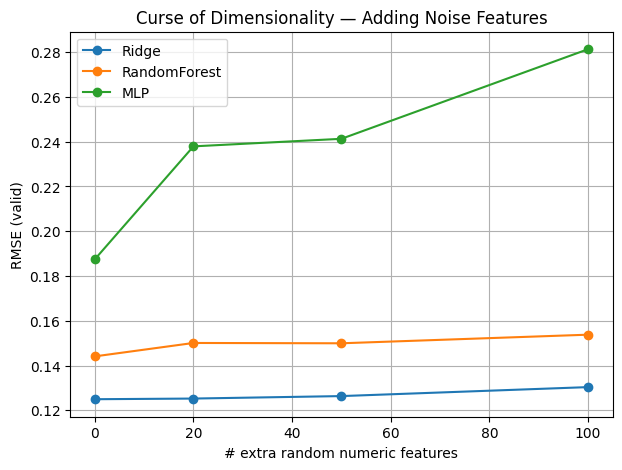

In [46]:
for k in noise_dims:
    # Add k random noise features to numeric data
    Xn_tr = add_numeric_noise_features(X_num_train, n_noise=k, rng=RANDOM_STATE) if k > 0 else X_num_train
    Xn_va = add_numeric_noise_features(X_num_valid, n_noise=k, rng=RANDOM_STATE) if k > 0 else X_num_valid

    # Recombine noisy numeric with categorical data
    X_tr_full, X_va_full = concat_num_cat_manual(Xn_tr, Xn_va)

    # Train each base model on the noisy data and record validation RMSE
    for name, model in base_models.items():
        m = clone(model).fit(X_tr_full, y_train)
        y_pred = m.predict(X_va_full)
        noise_results.append({"Model": name, "extra_noise": k, "RMSE": rmse(y_valid, y_pred)})

# Collect results and plot the effect of noise
df_noise = pd.DataFrame(noise_results)
plt.figure(figsize=(7,5))
for name in df_noise["Model"].unique():
    d = df_noise[df_noise["Model"] == name].sort_values("extra_noise")
    plt.plot(d["extra_noise"], d["RMSE"], marker="o", label=name)

plt.xlabel("# extra random numeric features")
plt.ylabel("RMSE (valid)")
plt.title("Curse of Dimensionality — Adding Noise Features")
plt.legend()
plt.show()

`Ridge` stays almost flat. Its RMSE rises slightly but remains low. That’s because Ridge uses regularization, which keeps noisy coefficients small. It can ignore irrelevant inputs fairly well.

`Random Forest performs` a bit worse as we add noise. Its RMSE increases slowly. Each tree can still find real patterns, but some splits now happen on random noise. The averaging helps, but the extra features still make learning slightly less efficient.

The `MLP` (neural network) struggles the most. Its RMSE climbs sharply as dimensions grow. Neural networks have many parameters, so when we feed them noisy features, they try to learn from that noise and lose focus on the real signal. Early stopping helps, but it cannot fully protect against too many irrelevant inputs.

In simple terms:

- Ridge is stable because it penalizes unnecessary complexity.
- Random Forest handles noise better than MLP but still weakens.
- MLP suffers most from the curse of dimensionality.

as we add meaningless features, all models lose accuracy, and the more flexible ones lose it faster.

---

We now test whether **PCA can fix the curse of dimensionality** we saw earlier. Instead of adding random features, we compress the numeric data into fewer, more informative dimensions.

**PCA**, or *Principal Component Analysis*, is a method that turns many correlated features into a smaller set of new features called components. Each component is a combination of the original variables that captures as much variation in the data as possible. The first few components usually explain most of the important structure, while later ones mostly contain noise. By keeping only the strongest components, we simplify the data without losing much information.

We start by building a grid of PCA component counts, from small numbers up to the maximum allowed by the data. Then for each number of components, we build a new preprocessing pipeline that includes PCA on the numeric part only. The categorical part stays unchanged.

We train each model again: Ridge, Random Forest, and MLP on these transformed versions and record their validation RMSE. Finally, we plot how RMSE changes as we keep more or fewer PCA components.

This experiment shows how dimensionality reduction affects different models.
* If RMSE drops when we apply PCA, it means removing noise and redundancy helped the model generalize.
* If RMSE rises when we use too few components, it means we lost important information.
* The best point is usually in the middle, where we keep enough components to capture most of the structure but not the noise.

PCA grid (n_components): [5, 10, 15, 20, 25, 30, 35]


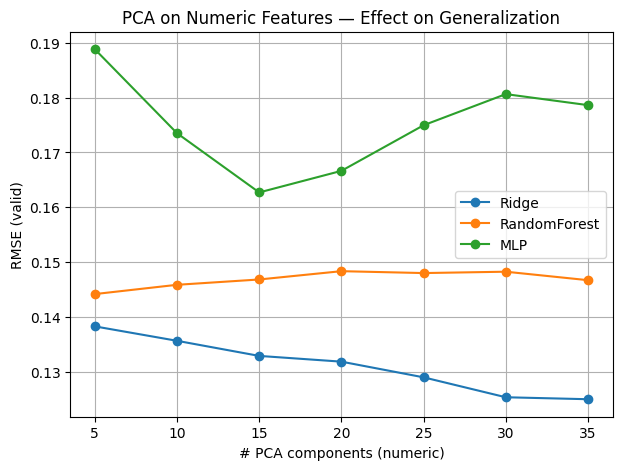

In [47]:
# PCA as a mitigation for high dimensionality (applied only to numeric features)

# Count numeric columns and define safe upper limit for PCA components
n_num = len(num_cols)
max_pca = min(n_num, X_train.shape[0])  # cannot exceed number of samples

# Helper to create a clean list of PCA component counts
def make_pca_grid(max_pca, step=5):
    # Create values like 5, 10, 15, ... up to max_pca
    return [k for k in range(5, max_pca+1, step) if k >= 1]

pca_components_grid = make_pca_grid(max_pca, step=5)
print("PCA grid (n_components):", pca_components_grid)

# Models to test under PCA
models_for_pca = {
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1),
    "MLP": MLPRegressor(hidden_layer_sizes=(64,64), max_iter=500, early_stopping=True, random_state=RANDOM_STATE),
}

# Run experiments across PCA dimensions
pca_results = []
for n_comp in pca_components_grid:
    preproc_pca = build_preprocessor(use_pca=True, n_components=n_comp)
    for name, model in models_for_pca.items():
        scores = eval_model_with_preprocessor(clone(model), preproc_pca)
        pca_results.append({
            "Model": name,
            "n_components": n_comp,
            **{k: v for k, v in scores.items() if k != "pipeline"}
        })

# Collect results and visualize the effect of PCA dimensionality
df_pca = pd.DataFrame(pca_results)
plt.figure(figsize=(7,5))
for name in df_pca["Model"].unique():
    d = df_pca[df_pca["Model"] == name].sort_values("n_components")
    plt.plot(d["n_components"], d["rmse"], marker="o", label=name)

plt.xlabel("# PCA components (numeric)")
plt.ylabel("RMSE (valid)")
plt.title("PCA on Numeric Features — Effect on Generalization")
plt.legend()
plt.show()

#### Ridge
Its RMSE drops steadily as we increase the number of components. That means Ridge benefits from keeping more of the numeric information, but PCA still helps clean up noise and redundancy. The lowest RMSE at higher component counts shows Ridge works best when it sees most of the original structure, but with the benefit of reduced correlation between features.

#### Random Forest
Its line is almost flat. Random Forests are not very sensitive to PCA because they do not rely on linear relationships. They can handle correlated or redundant features naturally. This stability means PCA neither hurts nor helps much for trees.

#### MLP (Neural Network)
Its RMSE starts high when there are very few components (around 5) and improves around 15 components, then worsens again after that. This pattern shows that PCA helps the MLP when it removes noise and reduces dimensionality, but if we reduce too much or keep too many, the network either loses signal or overfits again. The sweet spot is around 10–15 components, where it generalizes best.

What this tells us overall

- PCA can help models that are sensitive to high dimensional input (like Ridge and MLP) by removing redundant or noisy information.
- The best number of components depends on the model. Too few lose signal, too many bring back noise.
- Tree-based models, like Random Forests, gain little from PCA since they already manage correlated features internally.

In short, PCA mitigates the curse of dimensionality for models that rely on dense numeric input, while models that use feature splits (trees) stay stable either way.

---

Now we use PCA to find out **how much information each component keeps from the numeric data**. Each PCA component explains part of the total variation in the dataset. When we add them up, we see how much of the original information is preserved as we keep more components.

We fit PCA on the numeric training data only, not on validation or categorical features, to avoid data leakage. After fitting, we calculate the explained variance ratio for each component — that’s how much of the data’s variation that component represents. We then take the cumulative sum of those values and plot it.

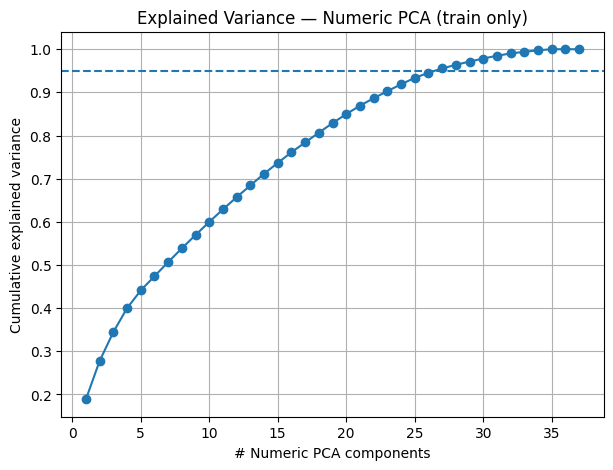

In [48]:
# Fit PCA only on numeric training features to study explained variance
pca_full = PCA().fit(X_num_train)

# Calculate cumulative explained variance
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Plot how much total variance is captured as we add more components
plt.figure()
plt.plot(np.arange(1, len(cum_var)+1), cum_var, marker="o")
plt.axhline(0.95, linestyle="--")  # 95% variance threshold
plt.xlabel("# Numeric PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained Variance — Numeric PCA (train only)")
plt.show()


The line in the plot climbs toward 1.0 (100 percent of total variance). The dashed line at 0.95 marks the point where we capture about 95 percent of the total information.

#### What this tells us
The first few components explain a large part of the data’s structure. After around 25–30 components, the line starts to flatten. This means the remaining components mostly contain noise or small details.

So, if we want to keep most of the useful information while reducing dimensionality, we can safely keep only the first 25–30 PCA components instead of all numeric features. That’s how we choose a good cutoff for PCA in practice — we keep enough components to cover most of the variance but not so many that we bring back noise.

# Summary

From all experiments, we learn several key lessons:

1. Increasing model complexity improves training accuracy but can hurt generalization. The validation curves show clear overfitting for deep trees and unregularized models.
2. Regularization methods such as L1, L2, and early stopping help control complexity. They keep models simpler, more stable, and better at predicting unseen data.
3. Ridge regression gives the most consistent results across validation folds, showing strong generalization and low variance.
4. The curse of dimensionality is real. Adding random features increases RMSE for every model, especially for flexible ones like Neural Networks.
5. PCA reduces dimensionality and removes noise. It improves performance for models sensitive to redundant numeric features while keeping most information intact.

Overall, we see that balancing simplicity and complexity is central to building models that generalize well. Regularization and dimensionality reduction are two reliable tools for keeping that balance.

# Which Model Performed the best and Why?
#### Best overall model: Ridge Regression
When it works best:

- When features are numeric and moderately correlated.
- When we apply regularization (alpha ≈ 1) to balance fit and smoothness.

Ridge keeps all coefficients but shrinks them, which avoids overfitting while still using all useful features. It gave the lowest `RMSE ≈ 0.12` (log SalePrice) and the highest `R² ≈ 0.91` in repeated K-fold validation. That means it predicts new houses consistently and doesn’t vary much between folds.

**Lasso** performed slightly worse (RMSE ≈ 0.13, R² ≈ 0.89).It helped with feature selection by zeroing unimportant coefficients, but removing those features cost a bit of accuracy.

#### Tree-Based Models (Decision Tree & Random Forest)

Best within trees: **Random Forest (≈ 200 trees, depth = 12)**
When it works best:
- When the data has non-linear interactions.
- When some features interact or have step-like effects.

A single Decision Tree overfits easily as depth grows. The Random Forest reduces this by averaging many trees built on random subsets of data. This lowered variance and gave `RMSE ≈ 0.14` and `R² ≈ 0.88`. It generalizes better than a single tree but not as smoothly as Ridge.

#### Neural Network (MLP)
Best version: **MLP with Early Stopping**
When it works best:
- When trained long enough to learn patterns but stopped early to prevent overfitting.

Without early stopping, `RMSE = 0.207` and `R² = 0.75.`
With early stopping, `RMSE = 0.195` and `R² = 0.78.`

## Dimensionality Reduction (PCA Effects)

`Ridge` improved slightly as PCA kept more components. It liked having cleaner, less-correlated numeric input.` Random Forest` barely changed, since trees handle correlation internally. `MLP` improved up to around 15 PCA components, then worsened. A good middle point that removed noise without losing key structure.

## Overall Summary

| Model             | Best Setup                      | RMSE (valid) | R² (valid) | Notes                                     |
| :---------------- | :------------------------------ | :----------- | :--------- | :---------------------------------------- |
| **Ridge**         | α = 1  (L2 regularization)      | ≈ 0.12       | ≈ 0.91     | Most stable generalization                |
| **Lasso**         | α = 0.01  (L1 regularization)   | ≈ 0.13       | ≈ 0.89     | Feature selection, slightly less accurate |
| **Random Forest** | 200 trees, depth = 12           | ≈ 0.14       | ≈ 0.88     | Good bias-variance balance                |
| **Decision Tree** | depth = 12                      | ≈ 0.20       | ≈ 0.74     | Overfits easily                           |
| **MLP w/ ES**     | 64-64 layers, early stopping on | ≈ 0.19       | ≈ 0.78     | Needs regularization to work              |
| **MLP no ES**     | same architecture no ES         | ≈ 0.21       | ≈ 0.75     | Overfits training data                    |

**Ridge Regression** is the best model for this dataset. It gives the strongest generalization, the lowest error, and the smallest variability across folds.